In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scdna_replication_tools.plot_utils import get_htert_cmap, get_clone_cmap, plot_clustered_cell_cn_matrix, plot_cell_cn_profile2, get_cna_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

In [4]:
import os
os.getcwd()

'/data1/shahs3/users/weinera2'

### Load and plot data for the CN and RT pseudobulks of hTERT WT sample SA039

In [6]:
bulk_cn_SA039 = pd.read_csv('scdna_replication_paper/analysis/sig_lines/SA039/cn_pseudobulks.tsv', sep='\t')

# treat each pseudobulk profile as a unique cell_id
bulk_cn_SA039 = bulk_cn_SA039.melt(id_vars=['chr', 'start'], var_name='cell_id', value_name='state')

# cluster_id corresponds to whether each profile is dataset, sample or clone level
bulk_cn_SA039['cluster_id'] = bulk_cn_SA039['cell_id'].apply(lambda x: x.split('_')[0])
# name of the dataset, sample or clone
bulk_cn_SA039['clone_id'] = bulk_cn_SA039['cell_id'].apply(lambda x: x.split('_')[1])

# replace underscores with spaces in cell_id column
bulk_cn_SA039['cell_id'] = bulk_cn_SA039['cell_id'].apply(lambda x: x.replace('_', ' '))

bulk_cn_SA039[['cell_id', 'cluster_id', 'clone_id']].drop_duplicates()

,cell_id,cluster_id,clone_id
0,sample SA039,sample,SA039
5451,clone A,clone,A
10902,clone B,clone,B
16353,clone C,clone,C
21804,clone D,clone,D


In [7]:
def plot_sorted_clone_cn_profiles(bulk_df, dataset, ax, chrom_labels_to_remove=[]):
    # subset the bulk_df to just the clone level profiles
    bulk_df = bulk_df.query('cluster_id=="clone"')
    
    plot_data = plot_clustered_cell_cn_matrix(
        ax, bulk_df, 'state', cluster_field_name='cluster_id', secondary_field_name='clone_id', chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )
    labels = plot_data.columns.get_level_values(0).values
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title('{}\nClone pseudobulk CN'.format(dataset))
    ax.set_xlabel('chromosome')

In [8]:
# load pseudobulk RT profiles
rt_SA039 = pd.read_csv('scdna_replication_paper/analysis/sig_lines/SA039/scRT_pseudobulks.tsv', sep='\t')
cn_s = pd.read_csv('scdna_replication_paper/analysis/sig_lines/SA039/s_phase_cells_with_scRT_filtered.tsv', sep='\t')
cn_s = cn_s[['chr', 'start', 'end', 'gc']].drop_duplicates()

rt_SA039 = pd.merge(rt_SA039, cn_s)
rt_SA039.chr = rt_SA039.chr.astype('str').astype('category')

/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
def plot_clone_rt_profiles(rt, ax, title_prefix='', chrom='1'):
    ''' Plot the RT profiles in the form of a scatter/line plot for each clone in the dataset.'''
    cols = [x for x in rt.columns if x.startswith('pseudobulk_clone') and x.endswith('model_rep_state')]
    clones = [x.split('_')[1].replace('clone', '') for x in cols]
    clone_cmap = get_clone_cmap()

    for clone_id, col in zip(clones, cols):
        # zoom in on representattive chromosome
        plot_cell_cn_profile2(
            ax, rt, col, color=clone_cmap[clone_id], chromosome='1', rawy=True,
            max_cn=None, scale_data=False, lines=True, label=clone_id,
            s=0.5, rasterized=True
        )

    ax.set_title('{}Clone pseudobulk RT'.format(title_prefix))
    ax.legend(title='Clone ID', loc='lower left')
    ax.set_ylabel('Pseudobulk RT\n<--late | early-->')

In [10]:
rt_SA039.head()

,chr,start,pseudobulk_model_rep_state,pseudobulk_hours,pseudobulk_cloneA_model_rep_state,pseudobulk_cloneA_hours,pseudobulk_cloneB_model_rep_state,pseudobulk_cloneB_hours,pseudobulk_cloneC_model_rep_state,pseudobulk_cloneC_hours,pseudobulk_cloneD_model_rep_state,pseudobulk_cloneD_hours,end,gc
0,1,1000001,0.947808,0.521921,0.944694,0.553064,0.954,0.46,0.935065,0.649351,1.000000,-0.000000,1500000,0.598332
1,1,1500001,0.957550,0.424495,0.949178,0.508221,0.968,0.32,0.952381,0.476190,1.000000,-0.000000,2000000,0.539498
2,1,2000001,0.959638,0.403619,0.955157,0.448430,0.968,0.32,0.952381,0.476190,0.972973,0.270270,2500000,0.594508
3,1,3000001,0.893528,1.064718,0.877429,1.225710,0.910,0.90,0.891775,1.082251,0.972973,0.270270,3500000,0.584572
4,1,4000001,0.788448,2.115518,0.765321,2.346786,0.830,1.70,0.753247,2.467532,0.864865,1.351351,4500000,0.482574


In [11]:
# re-orient cn_clone to be amenable for plotting a CN matrix instead of multiple CN profiles
rt_matrix = rt_SA039.copy()
# set chr, start as the index
rt_matrix = rt_matrix.set_index(['chr', 'start', 'end'])
# subset to only include the columns with 'relative_cn' substring
rt_matrix = rt_matrix[[c for c in rt_matrix.columns if ('model_rep_state' in c) and ('clone' in c)]]

# melt the dataframe to long-form such that the value column name is 'relative_cn' and the variable column name is 'cell_id'
rt_matrix = rt_matrix.reset_index().melt(id_vars=['chr', 'start', 'end'], value_vars=rt_matrix.columns, var_name='cell_id', value_name='rt')
# the first prefix of the cell_id column corresponds to the sample name
rt_matrix['sample_id'] = 'SA039'
# the second prefix of the cell_id column corresponds to the clone name
rt_matrix['clone_id'] = rt_matrix['cell_id'].apply(lambda x: x.split('_')[1].replace('clone', ''))
rt_matrix['cell_id'] = rt_matrix['cell_id'].apply(lambda x: x.split('_')[1].replace('clone', 'clone '))
rt_matrix.head()

,chr,start,end,cell_id,rt,sample_id,clone_id
0,1,1000001,1500000,clone A,0.944694,SA039,A
1,1,1500001,2000000,clone A,0.949178,SA039,A
2,1,2000001,2500000,clone A,0.955157,SA039,A
3,1,3000001,3500000,clone A,0.877429,SA039,A
4,1,4000001,4500000,clone A,0.765321,SA039,A


In [12]:
def plot_sorted_clone_rt_profiles(rt_matrix, title_prefix, ax, chrom_labels_to_remove=[]):
    ''' Plot the RT profiles in the form of a heatmap for each clone in the dataset. '''
    
    plot_data = plot_clustered_cell_cn_matrix(
        ax, rt_matrix, 'rt', cluster_field_name='sample_id', secondary_field_name='clone_id', chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove,
        cmap='viridis', vmin=0, vmax=1
    )
    labels = plot_data.columns.get_level_values(0).values
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title('{}Clone pseudobulk RT'.format(title_prefix))
    ax.set_xlabel('chromosome')

### Load and plot data showing the relationship between ancestral RT and the position of copy number breakpoints

In [13]:
datasets = ['SA039', 'SA906a', 'SA906b', 'SA1188', 'SA1292', 'SA1054', 'SA1055', 'SA1056']


In [14]:
def load_rt_data(datasets):
    # load dataset pseudobulk rt profiles
    rt = pd.DataFrame()
    for d in datasets:
        rt_path = 'scdna_replication_paper/analysis/sig_lines/{}/scRT_pseudobulks.tsv'.format(d)
        temp_rt = pd.read_csv(rt_path, sep='\t')
        if d=='SA039':
            temp_rt = temp_rt[[
                'chr', 'start', 'pseudobulk_cloneA_model_rep_state', 'pseudobulk_cloneA_hours', 'pseudobulk_model_rep_state', 'pseudobulk_hours'
            ]]
            temp_rt.rename(columns={
                'pseudobulk_cloneA_model_rep_state': '{}_cloneA_pseudobulk_rt'.format(d),
                'pseudobulk_cloneA_hours': '{}_cloneA_pseudobulk_rt_hours'.format(d)
            }, inplace=True)
        else:
            temp_rt = temp_rt[[
                'chr', 'start', 'pseudobulk_model_rep_state', 'pseudobulk_hours',
            ]]
        temp_rt.rename(columns={
            'pseudobulk_model_rep_state': '{}_pseudobulk_rt'.format(d),
            'pseudobulk_hours': '{}_pseudobulk_rt_hours'.format(d)
        }, inplace=True)
        
        if rt.empty:
            rt = temp_rt
        else:
            rt = pd.merge(rt, temp_rt)

    # set chr column to category
    rt.chr = rt.chr.astype('str')
    rt.chr = rt.chr.astype('category')

    rt['end'] = rt['start'] + 500000 - 1
            
    return rt
    

def load_cn_data(argv):
    # load dataset pseudobulk cn profiles
    cn = pd.DataFrame()

    col_name_change = {}
    for d in datasets:
        cn_path = 'scdna_replication_paper/analysis/sig_lines/{}/cn_pseudobulks.tsv'.format(d)
        temp_cn = pd.read_csv(cn_path, sep='\t')
        temp_cn = temp_cn.set_index(['chr', 'start'])
        
        # find the sample level pseudobulk cn column
        # note that it can start with dataset or sample prefix
        col_of_interest = [c for c in temp_cn.columns if c.startswith('dataset')]
        if len(col_of_interest)==0:
            col_of_interest = [c for c in temp_cn.columns if c.startswith('sample')]
        temp_cn = temp_cn[col_of_interest].reset_index()
        
        col_name_change[col_of_interest[0]] = '{}_pseudobulk_cn'.format(d)
        
        if cn.empty:
            cn = temp_cn
        else:
            cn = pd.merge(cn, temp_cn)

    # set chr column to category
    cn.chr = cn.chr.astype('str')
    cn.chr = cn.chr.astype('category')

    cn['end'] = cn['start'] + 500000 - 1

    cn = cn.rename(columns=col_name_change)

    return cn


def make_bk(cn, datasets):
    # create a table of copy number breakpoints for sample pseudobulk data
    # copy over the chromosome, start, and end columns
    cn_breakpoints = cn[['chr', 'start', 'end']].copy()
    for d in datasets:
        # create a column for the copy number breakpoints
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(d)] = cn['{}_pseudobulk_cn'.format(d)].diff().fillna(0).astype('int')
        # convert all nonzero values to 1
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(d)] = cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(d)].apply(lambda x: 1 if x!=0 else 0)

    return cn_breakpoints


def compute_relative_rt_and_cn(cn, rt, datasets):
    for d in datasets:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(d)
        temp_cn_col = '{}_pseudobulk_cn'.format(d)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(d)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(d)
        
        rt[relative_rt_col] = rt[temp_rt_col] - rt[ref_rt_col]
        cn[relative_cn_col] = (cn[temp_cn_col] / cn[temp_cn_col].mode().values[0]) - (cn[ref_cn_col] / cn[ref_cn_col].mode().values[0])
    
    return cn, rt


def merge_cn_and_rt_info(cn, rt, bk, datasets):
    # merge the cn and rt tables into one long-form dataframe
    df = []

    for d in datasets:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(d)
        temp_cn_col = '{}_pseudobulk_cn'.format(d)
        temp_bk_col = '{}_pseudobulk_cn_breakpoints'.format(d)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(d)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(d)
        
        temp_df = pd.DataFrame({
            'chr': cn['chr'], 'start': cn['start'], 'end': cn['end'], 'dataset': [d]*cn.shape[0],
            'WT_pseudobulk_rt': rt[ref_rt_col], 'WT_pseudobulk_cn': cn[ref_cn_col],
            'pseudobulk_rt': rt[temp_rt_col], 'pseudobulk_cn': cn[temp_cn_col], 'pseudobulk_bk': bk[temp_bk_col],
            'relative_rt': rt[relative_rt_col], 'relative_cn': cn[relative_cn_col]
        })
        
        df.append(temp_df)

    df = pd.concat(df, ignore_index=True)

    return df

In [15]:
# load the rt and cn data
rt = load_rt_data(datasets)
cn = load_cn_data(datasets)

# make a table of copy number breakpoints
bk = make_bk(cn, datasets)

# compute the relative RT and CN values for each dataset
cn, rt = compute_relative_rt_and_cn(cn, rt, datasets)

# merge the cn and rt tables into one long-form dataframe
df = merge_cn_and_rt_info(cn, rt, bk, datasets)

# rename bk column
df['breakpoint'] = df['pseudobulk_bk'].replace({0: 'No', 1: 'Yes'})
df.head()

,chr,start,end,dataset,WT_pseudobulk_rt,WT_pseudobulk_cn,pseudobulk_rt,pseudobulk_cn,pseudobulk_bk,relative_rt,relative_cn,breakpoint
0,1,1000001,1500000,SA039,0.944694,2.0,0.947808,2.0,0,0.003114,0.0,No
1,1,1500001,2000000,SA039,0.949178,2.0,0.957550,2.0,0,0.008373,0.0,No
2,1,2000001,2500000,SA039,0.955157,2.0,0.959638,2.0,0,0.004481,0.0,No
3,1,3000001,3500000,SA039,0.877429,2.0,0.893528,2.0,0,0.016099,0.0,No
4,1,4000001,4500000,SA039,0.765321,2.0,0.788448,2.0,0,0.023127,0.0,No


In [16]:
datasets = [
    'SA039', 'SA906a', 'SA906b', 'SA1292', 'SA1056', 'SA1188', 'SA1054', 'SA1055'
]
rt_paths = 'scdna_replication_paper/analysis/sig_lines/{}/scRT_pseudobulks.tsv'
cn_paths = 'scdna_replication_paper/analysis/sig_lines/{}/cn_pseudobulks.tsv'

# load the rt and cn data
rt = load_rt_data(datasets)
cn = load_cn_data(datasets)

# remove the site of p53 deletion on chr17
chr17_start_thresh = 21000001
cn = cn.loc[~((cn['chr'] == '17') & (cn['start'] <= chr17_start_thresh))]
rt = rt.loc[~((rt['chr'] == '17') & (rt['start'] <= chr17_start_thresh))]

# make a table of copy number breakpoints
bk = make_bk(cn, datasets)

# compute the relative RT and CN values for each dataset
cn, rt = compute_relative_rt_and_cn(cn, rt, datasets)

# merge the cn and rt tables into one long-form dataframe
df = merge_cn_and_rt_info(cn, rt, bk, datasets)

# create column to denote whether a particular bin has a gain, loss, or no cna
df['cna_type'] = 'unaltered'
for i, row in df.iterrows():
    if row['relative_cn'] > 0:
        df.loc[i, 'cna_type'] = 'gain'
    elif row['relative_cn'] < 0:
        df.loc[i, 'cna_type'] = 'loss'

# rename bk column
df['breakpoint'] = df['pseudobulk_bk'].replace({0: 'No', 1: 'Yes'})

df.head()

,chr,start,end,dataset,WT_pseudobulk_rt,WT_pseudobulk_cn,pseudobulk_rt,pseudobulk_cn,pseudobulk_bk,relative_rt,relative_cn,cna_type,breakpoint
0,1,1000001,1500000,SA039,0.944694,2.0,0.947808,2.0,0,0.003114,0.0,unaltered,No
1,1,1500001,2000000,SA039,0.949178,2.0,0.957550,2.0,0,0.008373,0.0,unaltered,No
2,1,2000001,2500000,SA039,0.955157,2.0,0.959638,2.0,0,0.004481,0.0,unaltered,No
3,1,3000001,3500000,SA039,0.877429,2.0,0.893528,2.0,0,0.016099,0.0,unaltered,No
4,1,4000001,4500000,SA039,0.765321,2.0,0.788448,2.0,0,0.023127,0.0,unaltered,No


In [17]:
def ancestral_rt_vs_sample_cna_histogram(df, ax):
    # histogram of RT values split by CNA type
    df['CNA type'] = df['cna_type']
    sns.histplot(
        data=df.query('dataset!="SA039"'), x='WT_pseudobulk_rt', hue='CNA type', 
        common_norm=False, stat='density', ax=ax, kde=True, bins=20,
        palette=get_cna_cmap(), cbar_kws={'edgecolor': 'k', 'linewidth': 0}
    )
    ax.set_xlabel('Ancestral hTERT RT\n<--late | early-->')
    ax.set_title('Location of sample CNAs')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 2 because we are doing 2 pairwise comparisons (bonferonni correction)
    gain = df.query('dataset!="SA039" and `CNA type`=="gain"')['WT_pseudobulk_rt']
    unaltered = df.query('dataset!="SA039" and `CNA type`=="unaltered"')['WT_pseudobulk_rt']
    loss = df.query('dataset!="SA039" and `CNA type`=="loss"')['WT_pseudobulk_rt']
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 2
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 2

    # add p-values to plot
    ax.text(0.1, 0.5, 'p={:.2e}'.format(gain_unaltered_pval), transform=ax.transAxes, ha='left', va='center', color=get_cna_cmap()['gain'])
    ax.text(0.1, 0.4, 'p={:.2e}'.format(loss_unaltered_pval), transform=ax.transAxes, ha='left', va='center', color=get_cna_cmap()['loss'])

    sns.despine(ax=ax, trim=despine_trim, offset=0)

In [18]:

def plot_sample_cn_profiles(cn, ax_cn, chrom_labels_to_remove=[]):
    # use the dataset column to denote the sample_id and dummy cell_id column
    cn['sample_id'] = cn['dataset']
    cn['cell_id'] = cn['dataset']
    
    # sort rows of cn by sample_id according to the order of SA039, SA906a, SA906b, SA1188, SA1292, SA1054, SA1055, SA1056
    # do this by first converting sample_id to a category and then sorting by the category
    cn['sample_id'] = cn['sample_id'].astype('category')
    cn['sample_id'] = cn['sample_id'].cat.set_categories(['SA039', 'SA906a', 'SA906b', 'SA1188', 'SA1292', 'SA1054', 'SA1055', 'SA1056'])
    cn = cn.sort_values('sample_id')
    cn['sample_id'] = cn['sample_id'].astype('str')

    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    sort_col = 'sort_col'
    sample_dict = dict([(y,x+1) for x,y in enumerate(cn['sample_id'].unique())])
    cn[cluster_col] = cn['sample_id']
    cn = cn.replace({cluster_col: sample_dict})
    cn[sort_col] = cn[cluster_col]

    plot_data = plot_clustered_cell_cn_matrix(
        ax_cn, cn, 'relative_cn', cluster_field_name=cluster_col, secondary_field_name=sort_col,
        raw=True, max_cn=None, cmap='bwr', chromosome=None, chrom_boundary_width=1, chrom_labels_to_remove=chrom_labels_to_remove,
        vmin=-1, vmax=1
    )

    labels = plot_data.columns.get_level_values(0).values
    ax_cn.set_yticks(np.arange(len(labels)))
    ax_cn.set_yticklabels(labels)
    ax_cn.set_title('Ploidy-normalized sample CN profiles')
    ax_cn.set_xlabel('chromosome')



In [19]:
def get_bkpt_cmap():
    cmap = {
        'No': 'grey', 0: 'grey',
        'Yes': 'green', 1: 'green'
    }
    return cmap


def plot_rt_bk_distributions(df, ax):
    # histogram of RT values split by breakpoint presence
    sns.histplot(
        data=df.query('dataset!="SA039"'), x='WT_pseudobulk_rt', hue='breakpoint', 
        common_norm=False, stat='density', ax=ax, kde=True, bins=20,
        palette=get_bkpt_cmap(), cbar_kws={'edgecolor': 'k', 'linewidth': 0}
    )
    ax.set_xlabel('Ancestral hTERT RT\n<--late | early-->')
    ax.set_title('Location of sample CNA breakpoints')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 3 because we are doing 3 pairwise comparisons (bonferonni correction)
    bk_yes = df.query('dataset!="SA039" and `breakpoint`=="Yes"')['WT_pseudobulk_rt']
    bk_no = df.query('dataset!="SA039" and `breakpoint`=="No"')['WT_pseudobulk_rt']
    pval = stats.ttest_ind(bk_yes, bk_no)[1] * 3
    # add p-values to plot
    ax.text(0.05, 0.9, 'p={:.2e}'.format(pval), transform=ax.transAxes, ha='left', va='center')
    sns.despine(ax=ax, offset=0, trim=despine_trim)


/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categ

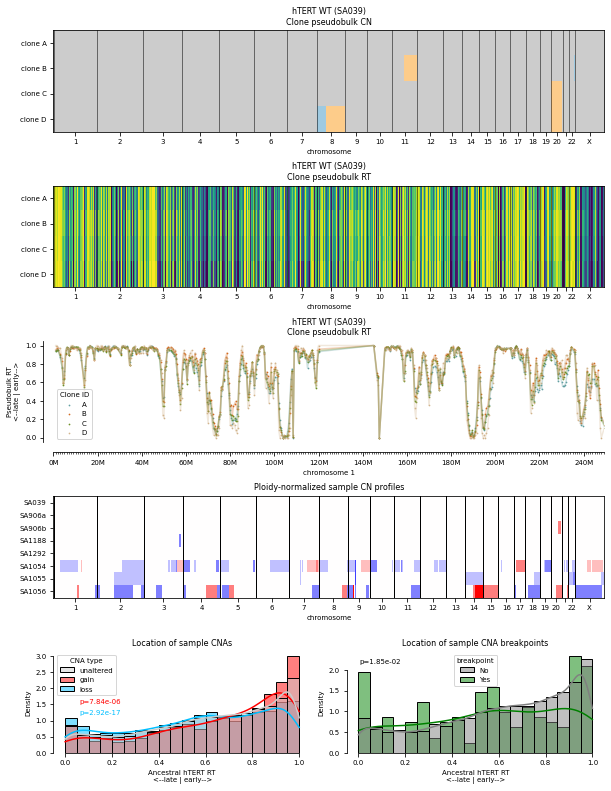

In [20]:
# create figure
fig, ax = plt.subplots(5, 2, figsize=(8.5, 11), tight_layout=True)

chrom_labels_to_remove = ['21']

# merge the 2 subplots in the first row
ax[0, 0].remove()
ax[0, 1].remove()
ax[0, 0] = fig.add_subplot(5, 2, (1, 2))

# merge the 2 subplots in the 2nd row
ax[1, 0].remove()
ax[1, 1].remove()
ax[1, 0] = fig.add_subplot(5, 2, (3, 4))

# merge the 2 subplots in the 3rd row
ax[2, 0].remove()
ax[2, 1].remove()
ax[2, 0] = fig.add_subplot(5, 2, (5, 6))

# merge the 2 subplots in the 4th row
ax[3, 0].remove()
ax[3, 1].remove()
ax[3, 0] = fig.add_subplot(5, 2, (7, 8))

# plot the sorted clone CN profiles for SA1292 in the 1st row
plot_sorted_clone_cn_profiles(bulk_cn_SA039, 'hTERT WT (SA039)', ax[0, 0], chrom_labels_to_remove=chrom_labels_to_remove)

# plot SA039 clone RT profiles in the 2nd and 3rd rows
plot_sorted_clone_rt_profiles(rt_matrix, 'hTERT WT (SA039)\n', ax[1, 0], chrom_labels_to_remove=chrom_labels_to_remove)
plot_clone_rt_profiles(rt_SA039, ax[2, 0], title_prefix='hTERT WT (SA039)\n', chrom='1')

# plot the sample CN profiles in the 4th row
plot_sample_cn_profiles(df, ax[3, 0], chrom_labels_to_remove=chrom_labels_to_remove)

# plot the gain/loss bias of sample CNAs in the bottom left corner
ancestral_rt_vs_sample_cna_histogram(df, ax[4, 0])

# plot the distribution of RT values split by breakpoint presence the bottom right corner
plot_rt_bk_distributions(df, ax[4, 1])

fig.savefig('scdna_replication_paper/manuscript/extended_data_figs/figED5.pdf', dpi=300, bbox_inches='tight')

plt.show()
